In [1]:
# If you are reading this notebook on a Binder, make sure to right-click the file name in
# the left-side file viewer and select `Open With > Notebook` to view this as a notebook

# <i class="fas fa-book fa-fw"></i> Classification Overview

At this point, we are ready to move on to a relatively different part of our machine learning journey, in particular, discussing the concepts of **classification** models. Before introducing many new ideas, let's take stock of the story we have been reading so far.

## Regression Recap

We started the last section of the book discussion Regression models. We first introduced many of our foundational ideas for machine learning and our ML Pipeline. This included defining our data, model, quality metric, learning algorithms. We also discussed how different choices for these components are ar result of different modeling decisions and priorities, and how those choices impact the reliability of our learned model.

We started our story talking about simple linear regression, where our model was in the form $y_i = w_0 + w_1x_i$. Our goal was to learn the assumed, but unknown, coefficients $w_0$ and $w_1$ directly from our training data $\{(x_i, y_i)\}_{i=1}^n$. We discussed all of the details of how to learn these coefficients by defining our quality metric $L(w) = \frac{1}{n} \sum_{i=1}^n \left(y_i - \hat{w}^Th(x)_i\right)^2$ and finding the minimum of this function by using gradient descent. We highlighted the importance of choosing which feature(s) to include in our model affecting how well we can learn more complicated relationships in our data.

We then began a discussion of how to evaluate our models. In particular, we discussed the trend that as we added more power (complexity) to our models, we would see a decrease in our training error, a hopefully good  thing, but maybe to an extreme that was actually costing us in how the model generalized in the future. We discussed the important of defining our evaluation metric that we care about to measure future performance, and how we approximate that with our test set. We discussed the abstract properties of how errors relate to model complexity in the discussion of bias and variance, and how to choose the right model complexity using a validation set or cross validation.

While the techniques of evaluating models by comparing something like validation error are quite general, we also were interested in investigating if we could discourage the model from overfitting in the first place by adding a concept of regularization. We discussed the impact of changing our quality metric to include a term for regularize our model, and how choices of how much we penalized the model could affect its performance.

We finally discussed the important modelling step of choosing which features to use in the first place, and a hope to find an automatic process to select the most important features for us. We saw that by using the specific regularizer of the L1 norm, we could  get feature selection as a useful side-effect. But, we importantly discussed the concept that our results of any feature selection algorithm are limited in the choices we include originally and how we define importance of features.

## Classification At a Glance

At a high-level, there is only a small change in our problem setup between regression and classification: the type of the labels/targets/outputs. In regression, our output $y$ is a numeric value such as a house price, a student grade, some measure of population growth, some measure of air quality, etc. Mathematically, we write this as the outputs $y$ in a regression task are either real numbers ($y \in \mathbb{R}$), integers ($y \in \mathbb{Z}$), or numbers in some range (such as $y \in [0, 1]$).

```{margin}
{{ref_ham}}\. "Ham" is commonly used as the opposite of "spam" when trying to detect spam emails. Alternatively we could simply call them "not spam", but "ham" is cuter.
```

In classification, instead of trying to predict a numeric value, we are trying to predict a value from a distinct set of classes. For example, we might want to predict if an email is spam or ham<sup>{{ref_ham}}</sup> ($y \in \{spam, ham\}$), or if an image contains a picture of a cat, dog, or bird ($y \in \{cat, dog, bird\}$). When the set of classes has two elements, we call this a **binary classification** problem, while we call a **multiclass classification** problem one where there are greater than two options. For the vast majority of our conversation in this section, we will discuss binary classification since it is simpler and many of the techniques for multiclass classification extend quite naturally from the ones we will discuss.

As mentioned in the {doc}`../../intro/index` chapter, our book will commonly focus on a single application as a *case study* on how to use the techniques that we are introducing. For this section, we will focus on the application of **sentiment analysis** as our case study. We will be classifying online reviews as being positive sentiment ($y = +1$) or negative sentiment ($y = -1$). The inputs of this model will be the text of the review (sentences) and the output will be the predicted class ($y \in \{+1, -1\}$).

## Feature Engineering

Before discussing how we can model and train a classification task, we have to discuss and important modeling prerequisite: how to represent our data.

```{margin}
{{ref_vector}}\. This is commonly notated that $x \in \mathbb{R}^d$ when discussing data inputs and $h(x) \in \mathbb{R}^D$ when discussing derived features. Reminder that in many cases, we simply use our data inputs directly as our features without doing any transformation or selection. But using $h(x) = x$ is a (often implicit) modeling choice, and different choices for your features will impact your results.
```

If you think carefully, you might realize there is potentially a glaring problem with how we might set up our problem, since we have not yet discussed how to represent text data such as sentences as data for our models. It turns out that most types of models assume your features are all numeric<sup>{{ref_vector}}</sup> and will not work natively with other types of data such as text data. So what can we do with our sentences to turn them into numbers? The field of *natural language processing* spends a lot of time thinking about how we can best represent text data. Just like our discussions of how you represent your features will affect your model, the same is true for how you transform text into numbers.

One of the simplest approaches is to use the **bag of words** representation for text data that counts the number of times each word appears in the text. For example, the sentence "Sushi was great, the food was awesome, but the service was terrible" cold be represented by a vector of counts. Each position of this vector corresponds to a particular word and the value at that position is the number of times that word appeared.

```{table} Bag of words representation of the sentence <br />"Sushi was great, the food was awesome, but the service was terrible"
:name: bow-sushi
| sushi | was | great | the | food | awesome | but | service | terrible |
|-------|-----|-------|-----|------|---------|-----|----------|----------|
| 1     |  3  |   1   |  2  | 1    | 1       | 1   | 1        | 1        |
```

The terminology "bag of words" comes from the fact that this representation does not care about the order that the words appear in the sentence. In this feature representation, the sentences "John ate an apple" and "an apple at John" are equivalent. Obviously this is a simplification of all of the details necessary to represent text, but it is one that works decently in practice. There are many more advanced ways of representing text that we won't discuss in too much detail other than the fact that many of them produce some vector of numbers in $\mathbb{R}^D$.

An unspecified note is what to do with punctuation such as periods or apostrophes. This is generally quite tricky in practice, so we will use the simplifying assumption that we don't care about punctuation and simply remove them. In effect, this would treat the words "it's" and "its" as the same word, which you can tell is a limitation.

So if we gathered a set of input data that is the review (text) and the predicted sentiment, we can apply this computation to every sentence in the dataset to come up with a numeric vector for each. `scikit-learn` provides a helpful pre-processor called [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to help us with this task. In the code cell below, we show how to use this class on a very small dataset. In our notation, we would treat the count in the output at row $i$ and index $j$ to be the feature $h_j(x_i)$.

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Make input data
data = pd.DataFrame([
    {"review": "Sushi was great, the food was awesome, but the service was terrible", "sentiment": +1},
    {"review": "Terrible food; the sushi was rancid.", "sentiment": +1},
])
print("Input Data")
print(data)
print()

# Transform into features with bag of words representation
counter = CountVectorizer()
bag_of_words = counter.fit_transform(data["review"]).toarray()

print("Feature names")
print(counter.get_feature_names_out())
print()

print("Features")
print(bag_of_words)

Input Data
                                              review  sentiment
0  Sushi was great, the food was awesome, but the...          1
1               Terrible food; the sushi was rancid.          1

Feature names
['awesome' 'but' 'food' 'great' 'rancid' 'service' 'sushi' 'terrible'
 'the' 'was']

Features
[[1 1 1 1 0 1 1 1 2 3]
 [0 0 1 0 1 0 1 1 1 1]]


## Building a Classifier

Let's now turn to how we can develop the ideas and concepts to build a classification model. In this chapter and the next, we will outline the idea for our first classification model called **logistic regression**. But before we get to that final model in the next chapter, we will start simple and build up to there with two other simpler models as starting points. The hope by telling the story in this way is we build up some important intuition and ideas before heading to some more complicated math and notation.

1. Simple Threshold Classifier
2. Simple Linear Classifier
3. End point: Logistic Regression

### 1. Simple Threshold Classifier

```{admonition} Big Idea
:class: tip

Use a list of "positive" and "negative" words to classify the review by which type of word appears most frequently.
```

Let's start by assuming that some hard working netizen on the internet has done most of the hard work for us to identify which words in English are more likely to be related to "positive sentiment" and ones that are more likely to be related to "negative sentiment". Suppose we downloaded their table of word categories shown in the table below.

<!-- TODO Easy to color? -->
```{table} Pre-defined list of words and their sentiments
:name: simple-model-1
| word     | sentiment |
|----------|-----------|
| sushi    | Neutral  |
| was      | Neutral  |
| great    | Good     |
| the      | Neutral  |
| food     | Neutral  |
| but      | Neutral  |
| awesome  | Good     |
| service  | Neutral  |
| terrible | Bad      |
| rancid   | Bad      |
| ...      |          |
```

Again, assuming we had such a reference in the first place, then we could build our first idea of a classifier.

```{prf:algorithm} Idea 1: Simple Threshold Classifier
:label: simple-threshold-classifier

**Input** A sentence $x$, and a reference table of word sentiments $T$

**Output** A prediction of the class $\hat{y} \in \{+1, -1\}$

1. `num_positive` $\gets$ Count the number of words in $x$ that are *positive* according to $T$
2. `num_negative` $\gets$ Count the number of words in $x$ that are *negative* according to $T$
3. if `num_positive` > `num_negative`:
    * predict $\hat{y} = +1$
4. otherwise:
    * predict $\hat{y} = -1$
```

So if we had this magical reference table, then this algorithm seems somewhat intuitive but you might imagine has some major limitations:

* Even amongst positive sentiment words, some words convey a more intense sentiment than others. "Awesome" is often considered to be a more positive claim than "good". So we will likely need a way to weight how positive or negative a word is instead.
* Single words are often not enough to capture meaning. According to the algorithm above, the sentence "not good" would likely be considered a positive sentiment! In reality, looking one word at a time may not sufficiently catch the context of the preceding sentence.
   * To be fair, this is not really a fault of the Simple Threshold Classifier, but a fault of our features only containing a single word. We will discuss later some approaches to potentially address this problem.
* It's not clear how we can even get this list of positive/negative words in the first place!

### 2. Simple Linear Classifier

In our last section of the book on regression, we discussed the surprising effectiveness of using linear models where we learn coefficients related to our features to use in in our predictions. What if we try to borrow that idea for a classifier? Instead of using a list of good/bad words, we can instead somehow learn coefficients for each word. We will come back and discuss details for how to learn coefficients for the words in a bit, but our goal would be to learn something like:

<!-- TODO Easy to color? -->
```{table} Pre-defined list of words and their sentiments
:name: linear-model-1
| feature | word     | sentiment |
|---------|----------|-----------|
| w_1     | sushi    | 0         |
| w_2     | was      | 0         |
| w_3     | great    | 1         |
| w_4     | the      | 0         |
| w_5     | food     | 0         |
| w_6     | but      | 0         |
| w_7     | awesome  | 2         |
| w_8     | service  | 0         |
| w_9     | terrible | -1        |
| ...     | ...      | ...       |
```

The intent here is that the more positive a coefficient is for a word, the more positive its sentiment is, and vice versa for negative coefficients. Words with coefficient 0 have neutral sentiment.

Then using our bag of words feature extraction $h(x)$ on a sentence $x$, we can now use these coefficients to make predictions. We define the notion of a $Score(x_i)$ to be a number that, if more positive means the sentence has more positive sentiment, and if more negative, has more negative sentiment. We use the notation $s_i$ as shorthand for $Score(x_i)$.

$$s_i = Score(x_i) = \sum_{j=0}^D w_j h_j(x) = w^Th(x)$$

Using this score, we can then make our prediction $+1$ when the $Score$ is positive, otherwise negative. The $sign$ function returns $+1$ if the number is positive, and $-1$ otherwise. In the case of the $Score$ being exactly 0, you have to make a determination of if you should predict positive, negative, or something else entirely. So now our predicted labels are:

$$\hat{y}_i = sign(Score(x_i)) = sign(\hat{s}_i) = sign(\hat{w}^Th(x_i))$$

With the sentence "The sushi was great, the food was awesome, but the service was terrible" (ignoring all 0 coefficients), $s_i = 1 c\dot 1 + 2 \cdot 1 -1 \cdot 1 = 2$, which means our prediction for this sentence is $\hat{y}_i = +1$.

<!-- TODO update reference -->
We actually won't discuss how to learn the coefficients for our linear model in this chapter, instead saving that discussion for the next chapter. So for now, let's just pretend we have some learning algorithm that tells us the coefficients based on our training data.

## Decision Boundaries

Consider a simplified model where we only have two features/coefficients

```{table} Pre-defined list of words and their sentiments
:name: linear-model-2
| feature         | word          | sentiment |
|-----------------|---------------|-----------|
| $\hat{w}_0$     | *(intercept)* | 0.0       |
| $\hat{w}_1$     | awesome       | 1.0       |
| $\hat{w}_2$     | awful         | -1.5      |
```

To understand the predictions of this model, it sometimes helps to visualize what the model would predict for any setting of the features $h_1(x)$ and $h_2(x)$. In general, the score for a sentence with using these coefficients is the following.

$$\hat{s} = 1 \cdot \text{#awesome} - 1.5 \cdot \text{#awful}$$

So let's consider plotting all possible values of $(\text{#awesome}, \text{#awful})$ and plotting all of the ones with score $\hat{s} > 0$ as positive and the one with score $\hat{s} < 0$ as negative. We highlight the region where $\hat{s} = 0$ exactly as the **decision boundary** in black. Note that all of the places below the line are predicted positive, since in that region all of the scores are *positive*. Above the line all of the scores are *negative* so the predictions are negative. Also note that the decision $\hat{s} = 0$ is a line! We call this model a *linear classifier* because its decision boundary, where the decisions would switch from positive/negative, is a linear function. To make this plot, we actually just imagined making a prediction for every possible $(\text{#awesome}, \text{#awful})$, for example $(5, 2)$, and then finding its prediction $Score((5, 2)) = 1 \cdot 5 - 1.5 \cdot 2 = 2$.

```{figure} 2d-decision-boundary.png
:alt: A picture of a decision boundary (explained in last paragraph)
```

```{margin}
{{ref_hyperplane}}\. Also called a hyperplane
```

While we show this decision boundary  as a 2D plot (using color to highlight positive/negative predictions), we can also think about these predictions as a 3D plot where the z-axis shows the value of the $Score(x)$. Because coefficients are a linear function, when visualizing the outputs $Score(x)$ for every input $(h_1(x), h_2(x))$, we would draw this function as a *plane*<sup>{{ref_hyperplane}}</sup>. Note that the scores are linear in terms of the inputs and a higher point for the plan corresponds to a larger $Score$. What our last plot was showing was the *projection* of this 3D plot into 2D, where we used color to depict whether or not the $Score$ was positive/negative. Usually these plots are less popular because they are more complicated, and sometimes hide the important details of where the decision boundary is. But they are still a helpful tool to think about what is going on here.

```{figure} 3d-decision-boundary.png
:alt: A picture of a decision boundary in 3D (explained in last paragraph)
:width: 50%
:align: center
```

One final way to visualize these predictions and the decision boundary is to color the hue of the positive/negative regions by the magnitude of the score. Where the scores are very high, using a darker blue; when the scores are very low, using a darker yellow; when the scores are near 0, shading them more white. This view is essentially the same as the first, but is helpful to show some notion of *confidence* the model has in its predictions. If it is predicting something near the decision boundary, the scores are closer to 0 and the coloring shows it is less *confident* about the prediction in that region due to it being near the dividing line.

```{figure} shaded-decision-boundary.png
:alt: A side-by-side depiction of our original decision boundary, and one with the predictions shaded (described in last paragraph).
```

<!-- TODO Add sli.do poll about shifting intercept -->

### More Complicated Decision Boundaries
Note that in all of these cases, with the model we are using being a linear model, the decision boundaries we learn will be linear. If we wanted to learn a more complicated boundary, we would need to use a more complicated model. As discussed in great detail earlier, one way of making a model more complex is using more features to hopefully capture more complicated relationships in the data.

```{figure} complex-boundary.png
:alt: A more complicated decision boundary that does not just follow a line.
:width: 50%
:align: center
```

For example, instead of just using simple word counts, we could also include the word counts squared or with other mathematical transformations. In text processing, one common way to represent more complicated features is to look at more words at a time. In our simple bag-of-words features, we were making our model a **unigram** model since it only looked at one word (uni) at a time. Remember we discussed that this feature representation is inherently limited as it is unable to capture concepts represented in multiple words such as "Not good." Instead, another approach is to count up occurrences of pairs of words in a **bigram** model.

So with our sentence, "Sushi was good, the food was good, the service was not good", the unigram representation would have the features was shown above in {ref}`Bag of Words <bow-sushi>`. However, if we switched to a bigram representation of our data, we would have a feature for each adjacent pair of words that appear in this sentence as shown in the table below.

```{table} Bigram representation of the sentence <br />"Sushi was great, the food was awesome, but the service was terrible"
:name: bigram-sushi
| sushi was | was good | good the | the food | food was | the service | service was | was not | not good |
|-----------|----------|----------|----------|----------|-------------|-------------|---------|----------|
| 1         | 2        | 2        | 1        | 1        | 1           | 1           | 1       | 1        |
```

We can generalize this concept to an **n-gram** model that looks at the last $n$ words at each point. Clearly the larger $n$ is, the more complicated our set of features will be as there are more and more possible combinations of $n$ words as $n$ grows. Everything we have discussed before about model complexity applies here when considering using more and more context in the counts.

## Evaluating Our Classifier

TODO Quality Metric highlight ML Pipeline

<!-- TODO Update reference to next chapter -->
So again, supposing we have some way to learn coefficients for our linear classifier, let's discuss how we might evaluate it. This will help us start the conversation of how we actually learn these coefficients in the next chapter. In this section, we will outline the *Quality Metric* we are interested in using to evaluate how good a particular predictor is.

In some sense, it is a bit easier to discuss the error of a classification system. In binary classification, in particular, there are really only two possibilities for a prediction: it is either right or it is wrong. We can actually break down the "wrong" case into two possibilities that are often useful to name explicitly. The two types of being wrong are:

* If the true label was positive ($y = +1$), but the predicted label was negative ($\hat{y} = -1$). This is often called a **False Negative**.
* If the true label was negative ($y = -1$), but the predicted label was positive ($\hat{y} = +1$). This is often called a **False Positive**.

In some scenarios you might care specifically about which type of error is happening, but in many cases, we simplify to ignore these sub-cases and just consider an error to be an error, regardless of type.

<!-- TODO It seems this is overflowing off the page if the browser is too small?-->
```{margin}
{{ref_indicator}}\. 📝 *Notation:* $\indicator{c}$ is an indicator function that evaluates to 1 if $c$ is true, else 0.
```

We can then define the **classification error** of our predictor to be the following. Note that, as defined, the error will be a number between 0 and 1, where a higher number indicates a larger fraction of the examples were classified incorrectly.

$$error(\hat{f}) = \frac{\text{# mistakes}}{\text{# examples}} = \frac{1}{n}\sum_{i=1}^n \indicator{\hat{y}_i \neq y}$$

Similarly, we can also define the concept of **classification accuracy** as we do below. Note that the special relationship in how accuracy and error are opposites in the binary classification setting.

$$accuracy(\hat{f}) = \frac{\text{# correct}}{\text{# examples}} = 1 - error(\hat{f}) = \frac{1}{n}\sum_{i=1}^n \indicator{\hat{y}_i = y}$$

### Interpreting Error/Accuracy

While, in some sense, classification error/accuracy are easier to understand that our more complicate $MSE$ from regression, we need to be careful with how we interpret our evaluation metrics here.

We might expect that your model should beat at least random guessing. So if you compare your model to a baseline model that just randomly picks a label, our accuracy should be better than random.  For binary classification, we might expect that accuracy to be at least 50% and for multi-class classification an accuracy of at least $1/k$. Besides that, we might believe that a accuracy closer to 1 inherently means a model that is good at the learning task.

However, consider the case of building a model to predict whether or not you would click on an ad on a webpage (positive label is you click, negative is you don't). It turns out, that if we just always predict a negative label, we would have an accuracy around [94%](https://www.smartinsights.com/internet-advertising/internet-advertising-analytics/display-advertising-clickthrough-rates/)! The reason for this is in this example, there is a **class imbalance** present, where most of the labels are negative since most people don't click on most ads they see. This simple classifier that just always predicts the majority class is called the **majority class classifier**. So in order for an accuracy to be considered "good", it should be doing at least better than the majority class classifier.

So what should we do about this? Well, we should always be asking critical questions of why we see the accuracy we do and how we should interpret our results. So a common workflow to consider your model's performance might ask the following questions:

* Is the a class imbalance present in my data?
* How does my model's accuracy compare to some sort of baseline (e.g., a random guesser, or a majority class classifier)
* *What does my application need in terms of our accuracy?* What's good enough for the user experience? What are the impacts of the errors we make.

Importantly with that last question, we don't ask "What if an error happens?", but "What is the cost of that error?" In machine learning applications, errors are a fact of life that cannot be avoided. Our hope is to minimize errors, but with statistical modeling, errors are guaranteed. So the question we have to ask is not "if" an error happens, but "how many" and what those errors "cost".

(classification:confusion_matrix)=
## Confusion Matrix

While classification accuracy and error are intuitive, they are often lacking in the fact that they smooth over all possible mistakes that can happen. We indicated before, that we might care about the specific types of error happening:

* $\hat{y} = +1, y = -1$ or a False Positive
* $\hat{y} = -1, y = +1$ or a False Negative


It often helps to plot out the types of errors that occur in a **confusion matrix**. The rows of this matrix correspond to the possible true labels (positive, negative) and the columns, the possible predictions (positive, negative). The matrix outlines all possible combinations of these cases.

```{figure} confusion_matrix.png
:alt: A grid showing the confusion matrix (described below)
```

The four regions of this matrix correspond to the possible combinations of our labels and predictions.

* $\hat{y} = +1, y = +1$ is a **True Positive**
* $\hat{y} = +1, y = -1$ is a **False Negative**
* $\hat{y} = -1, y = +1$ is a **False Positive**
* $\hat{y} = -1, y = -1$ is a **True Negative**

In the following code sample, we show a `scikit-learn` function for plotting these confusion matrices on some synthetic examples of labels and predictions.

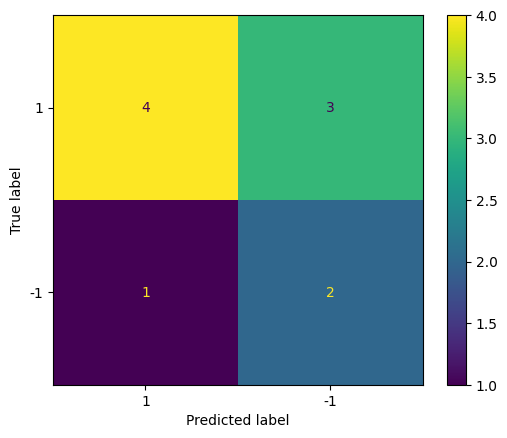

In [3]:
from sklearn.metrics import ConfusionMatrixDisplay

y =     [1,  1, -1, 1, -1, 1,  1,  1, 1, -1]
y_hat = [1, -1,  1, 1, -1, 1, -1, -1, 1, -1]

_ = ConfusionMatrixDisplay.from_predictions(y, y_hat, labels=[1, -1])

This confusion matrix encodes more information than accuracy/error do on their own. You can always recover these from the confusion matrix though. For example, in that last code output the accuracy of that classifier would be $\frac{4 + 2}{4 + 3 + 1+ 2} = 0.6$.

```{margin}
{{ref_positive}}\. Note deciding which label is considered "positive" and "negative" is somewhat arbitrary. All of the terminology can be flipped if you change your terminology. Note that in many cases where are model is trying to detect something (e.g., spam or a disease), the "positive label" is often the presence of that thing even if that thing being present isn't actually a good thing.
```

So with this idea of a confusion matrix in mind, we might now ask "Which is worse? A false negative or a false positive?" Like most of our interpretations of our ML models, this entirely depends on context. Consider the "cost" of these two types of errors in two different scenarios. What is the cost incurred by each mistake in the following situations?<sup>{{ref_positive}}</sup>

```{dropdown} Spam Detection (where the positive label = spam email)

* False Negative ($\hat{y} = -1, y = +1$): Annoying that we let a spam email into your inbox
* False Positive ($\hat{y} = +1, y = -1$): Blocked someone's (ham) email and now you might get in trouble for not reading an email you were supposed to.

I can tell you that even though I get a lot of emails, a False Positive for spam detection is *way* worse for being a teacher and potentially missing your students' emails!
```

```{dropdown} Medical Diagnosis (where the positive label = condition/disease is present)

* False Negative ($\hat{y} = -1, y = +1$): Condition/disease goes untreated
* False Positive ($\hat{y} = +1, y = -1$): Potentially give a wasteful treatment for that condition/disease

Depending on the condition/disease, how we weigh these is vastly different. For example, in the COVID-19 pandemic it was likely that we can afford to have a at-home-test that was biased towards False Positives. The cost of incorrectly telling someone they had COVID when they didn't is they stay home and isolate, but the cost of a False Negative is the potential spread to many other people.
```

So as we see from these examples, context entirely matters here when evaluating which type of error is worse. Remember, errors in ML systems are a given, so it's a question of "when" and "how many" errors happen, not "if". Depending on how you evaluate these types of errors, you may even choose to not use an ML system there in the first place. For example, many AI ethicists assert that we should draw a firm line in the use of AI in warfare, as the cost of mistakenly taking a life is far too great for any computer to decide.

Another big question to ask is who is affected by these mistakes? As we saw earlier in the book, we provided an example of error rates in facial recognition systems vary across demographics such as sex and race ([source](https://www.nytimes.com/2018/02/09/technology/facial-recognition-race-artificial-intelligence.html?module=inline)). So here the problem is not that the model makes errors (all models do), but the rates these errors disproportionately impact certain demographic groups negatively.

## Laundry List of Classification Metrics

With this concept of the confusion matrix, we can now introduce a laundry list of metrics that people use to weigh the cost of errors in various systems. We do not dive into most of these metrics in detail, but we provide some of the most commonly used ones here. If you're interested, you can learn more about these metrics and many more possible ones [here](https://en.wikipedia.org/wiki/Confusion_matrix).

For all of the following metrics, we use the following notation:

````{grid}

```{grid-item-card} Individual Counts
:columns: 6
* $C_{TP} = \text{# True Positive}$
* $C_{FP} = \text{# False Positive}$
* $C_{TN} = \text{# True Negative}$
* $C_{FN} = \text{# False Negative}$

```

```{grid-item-card} Aggregate Counts
:columns: 6
* $N_P = C_{TP} + C_{FN}$
* $N_N = C_{TN} + C_{FP}$
* $N = N_P + N_N$
```
````

**Classification Metrics**

````{grid}

```{grid-item-card} Error Rate
:columns: 4
$$\frac{C_{FP} + C_{FN}}{N}$$
```

```{grid-item-card} Accuracy Rate
:columns: 4
$$\frac{C_{TP} + C_{TN}}{N}$$
```

```{grid-item-card} False Positive Rate (FPR)
:columns: 4
$$\frac{C_{FP}}{N_N}$$
```

```{grid-item-card} False Negative Rate (FNR)
:columns: 4
$$\frac{C_{FN}}{N_P}$$
```

```{grid-item-card} True Positive Rate (TPR) or Recall
:columns: 4
$$\frac{C_{TP}}{N_P}$$
```
```{grid-item-card} Precision
:columns: 4
$$\frac{C_{TP}}{C_{TP} + C_{FP}}$$
```
```{grid-item-card} F1-Score
:columns: 4
$$2\cdot\frac{Precision \cdot Recall}{Precision + Recall}$$
```
````

An English explanation for what each means is outlined below:

* Accuracy/Error Rate: Already discussed
* FPR: The rate of all the examples that are truly negative that are labelled as positive. An FPR of 1 means every negative example was mistakenly labeled as positive.
* FNR: Same as FPR, but for truly positive examples that are labeled negative.
* TRP/Recall: Of all of the truly positive examples, what fraction of them were predicted positive. A Recall of 1 means every positive example was labelled positive. This is called "Recall" in the terminology that the positive label is often trying to find some condition (e.g., a disease) and we are interested in how many of the instances of that disease we correctly find.
* Precision: Of all of the things predicted as a positive label, which fraction of them are actually positive examples. A Precision of 1 means every example predicted positive is actually a positive example.
* F1-Score: A metric that tries to measure both precision and recall at the same time. An easy way to increase recall is to decrease precision (predict all examples positive), and vice versa. The F1-score combines both so you need both good precision and recall to get a high F1-Score.

Don't worry too much about those details right now, we just want to present these metrics as a reference to look back on when asked to interpret a particular metric.

## Aside: Learning Theory

Before concluding this introductory chapter on classification, we want to take a quick segue to the theoretical background behind machine learning. In particular, we want to discuss the role of how much training data we have on the quality of our models.

There is a lot of theoretical machine learning research to find how much data we might need to guarantee a model with a particular error rate. Typically more (quality) data is better, but you can actually find bounds on how much data is necessary. We don't discuss all of these results here, but provide a link to some extra resources ona the side here. What we do want to discuss is the role of how increasing our amount of training data affects our model's error.

```{figure} learning_rate.png
:alt: A graph showing how the true error decreases as training data size increases, but only down to some limit.
:align: center
```

It's important to note that in this graph we are considering a *single model complexity* and varying the amount of data we give it. When there is too little data, the model complexity might be too great and it will overfit. As we increase the training data size, but keep the model complexity the same, we see a decrease in true error. Do we expect the true error to go to zero in the limit that we have infinite training data?

This decrease in error we are seeing is a result in the variance of the model decreasing as we add more data. A 20-degree polynomial has less room to wiggle around when there are 2 billion training points. But remember that variance is not the only source of error! Bias and the irreducible noise are too! Adding extra training data doesn't actually remove our noise. Additionally, it doesn't decrease our model's bias either! If linear model is being used to approximate a degree 3 polynomial, that bias (being the wrong model type) will be wrong no matter how much data we throw at it. In other words, the true error in the limit of infinite training data will be the bias (squared) plus the irreducible noise.

How do we expect a more complicated model would fair as you increase the training data size? So for example, what if we compared these learning curves for a model trained on unigram features vs one trained on bigram features. We would see the same overall pattern that true error decreases over time, but there might be some specifics differences to note.

```{figure} compare_learning_rate.png
:alt: Comparing two learning curves, the bigram model falls to a lower true error with infinite training data.
:align: center
```

So some things to note:
* We might expect that the true error for the more complicated model to be *higher* than the simpler model when there isn't a lot of training data. This might be a result of overfitting causing the true error to be higher. We do note that this isn't a guarantee though since it depends a lot on the data and modeling task.
* In the limit where we have infinite training data, the true error of the bigram model also doesn't reach zero, but it is lower than the unigram model. Why is this? The irreducible noise is the same, but the bias of the more complicated is lower.

## Coming Up

<!-- TODO update reference below -->

So in this chapter, we have introduced the concept and terminology for classification and how to evaluate classification models. What we have not discussed is how we actually learn the coefficients for our linear model. We will discuss this in detail on our next chapter on Logistic Regression.


<!-- TODO add checkpoint questions -->